In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Decision Trees and Random Forests


**Random Forests** are a non-parametric algorithm that is an example of an *ensemble* method. It aggreates the results of an ensemble of simple estimators.

Random forests are built on **descision trees**. Decision trees are an intuitive way to classify or label object by asking a series of questions.

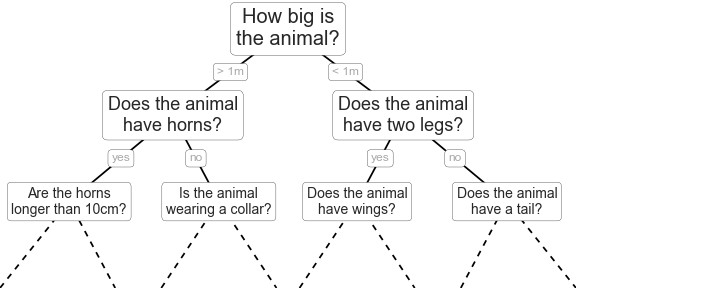

### Creating a Decision Tree

We'll start with 2-D data with four possible class labels;

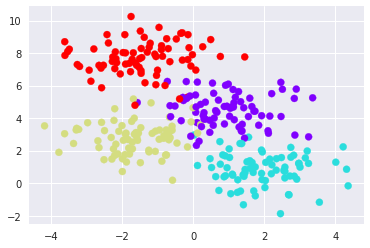

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

This process of fitting a decision tree to our data can be done in Scikit-Learn with the `DecisionTreeClassifier` estimator:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [12]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

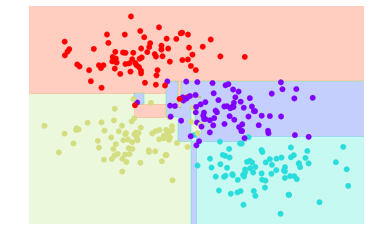

In [13]:
visualize_classifier(DecisionTreeClassifier(), X, y)

This is the tree at five levels deep and we can see it is already overfitting the data. The red rectangle in the yellow section and the long skinny purple rectangle reaching to the end of the graph are result of outliears instead of the intrinsic data.

We could also see this overfitting by training the model on different subsets of the data. In some place they will provide consistent results,  while in other places, the two trees give very different classifications.

The inconsistencies tend to happen where the classification is less certain, so by using information from both of these trees, we might come up with a better result! This is the general idea behind ensemble learning methods.

### Ensembles of Estimators: Random Forests

Combining multiple overfitting estimators to reduce the effect of overfitting underlies the ensemble method of **bagging**. **Bagging** uses an ensemble(grab bag) of *parallel* estimators, that each over-fit, and average the results.

A **random forest** is just an ensemble of randomized decision trees.

his type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here:

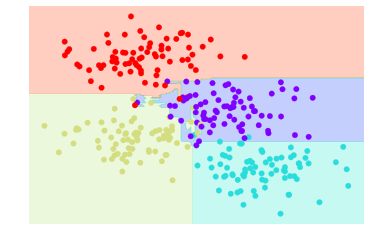

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

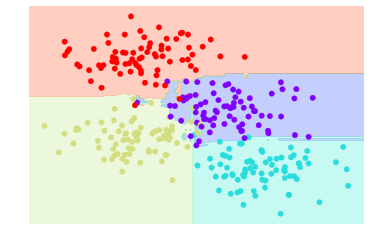

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

### Random Forest Regression

Random forests can also be made to work in the case of regression. The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

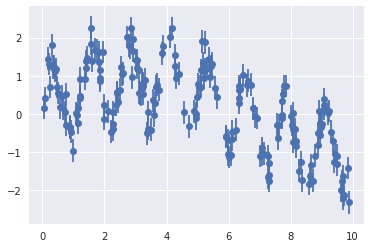

In [16]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

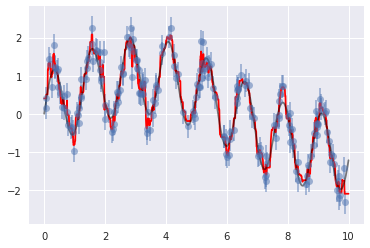

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

### Example: Random Forest for Classifying Digits

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()

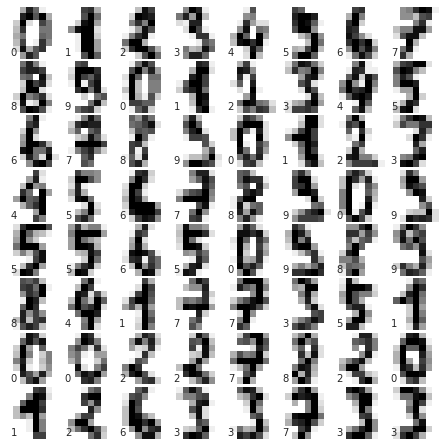

In [29]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    ax.text(0, 7, str(digits.target[i]))

In [30]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [31]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       1.00      0.98      0.99        44
          2       0.95      1.00      0.98        42
          3       0.98      0.96      0.97        46
          4       0.97      1.00      0.99        37
          5       0.98      0.98      0.98        48
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



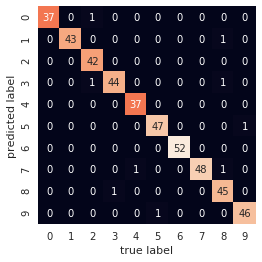

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [37]:
from sklearn.naive_bayes import GaussianNB
model_G = GaussianNB()
model_G.fit(Xtrain, ytrain)
y_model_G = model_G.predict(Xtest)

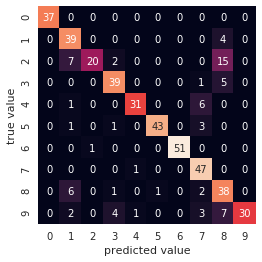

In [38]:
mat = confusion_matrix(ytest, y_model_G)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

In [39]:
from sklearn.metrics import accuracy_score
print('Random Forest: ', accuracy_score(ytest, ypred))
print('Naive Bayes Gaussian: ', accuracy_score(ytest, y_model_G))

Random Forest:  0.98
Naive Bayes Gaussian:  0.833333333333


The **random forest** was a big improvement over the **naive Bayes guassian** classifier we used earlier in the handbook.

### Summary

Advantages of Random Forests;
+ Both training and prediction are very fast, because of the simplicity of the underlying decision trees. Both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
+ The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).
+ The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

Disadvantages of random forests;
+ Results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.